In [1]:
# import modules
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# load data
trainging_data = datasets.FashionMNIST(
    root = "../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="../data",
    train=False,
    download=True,
    transform=ToTensor()
)

26422272it [00:56, 470354.92it/s]                              


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



29696it [00:00, 95951.34it/s]                           


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



4422656it [00:10, 439274.50it/s]                              


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



6144it [00:00, 6758406.45it/s]          

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



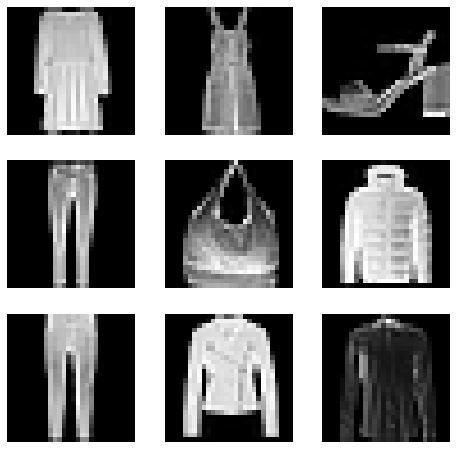

In [2]:
# check data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainging_data), size=(1,)).item()
    img, label = trainging_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
print("img: ", trainging_data[3][0].shape)
print("idx: ", trainging_data[3][1])

img:  torch.Size([1, 28, 28])
idx:  3


In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(trainging_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


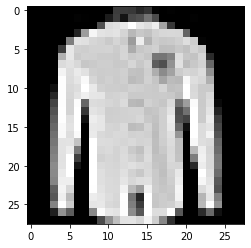

Label: 6


In [5]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [31]:
import torch.nn.functional as F

class MLP(torch.nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(28 * 28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 10),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [32]:
# parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device: ", device)
lr = 0.001
epochs = 20
criterion = torch.nn.CrossEntropyLoss().to(device)

device:  cpu


In [45]:
# models
models = [MLP().to(device) for _ in range(6)]

In [46]:
# optimizers
sgd = torch.optim.SGD(models[0].parameters(), lr=lr)
sgd_momentum = torch.optim.SGD(models[1].parameters(), lr=lr, momentum=0.9)
sgd_nestrov_momentum = torch.optim.SGD(models[2].parameters(), lr=lr, momentum=0.9, nesterov=True)
adaGrad = torch.optim.Adagrad(models[3].parameters(), lr=lr)
rmsProp = torch.optim.RMSprop(models[4].parameters(), lr=lr)
adam = torch.optim.Adam(models[5].parameters(), lr=lr)

In [47]:
def train(epochs, optimizer, model_fn, model):
    print("Optimizer :")
    print(optimizer.__str__())
    train_loss_arr, test_loss_arr = [], []
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (X_train, y_train) in enumerate(train_dataloader):
            # tarin
            model.train()
            optimizer.zero_grad()
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            pred = model(X_train)
            loss = criterion(pred, y_train)
            train_loss += loss
            loss.backward()
            optimizer.step()
            if batch_idx % 300 == 0:
                loss, current = loss.item(), batch_idx * len(X_train)
                print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataloader.dataset):>5d}]")
        train_loss /= len(train_dataloader)
        train_loss_arr.append(train_loss)
        
        test_loss, correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X_test, y_test in test_dataloader:
                X_test = X_test.to(device)
                y_test = y_test.to(device)
                pred = model(X_test)
                test_loss += criterion(pred, y_test).item()
                correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()
            test_loss /= len(test_dataloader)
            test_loss_arr.append(test_loss)
            correct /= len(test_dataloader.dataset)
            print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    torch.save(model.state_dict(), model_fn)
    return train_loss_arr, test_loss_arr

In [48]:
# SGD
sgd_train_loss_arr, sgd_test_loss_arr = train(epochs, sgd, "sgd.pth", models[0])

Optimizer :
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)
loss: 2.500505  [    0/60000]
loss: 0.880402  [19200/60000]
loss: 0.782873  [38400/60000]
loss: 0.482004  [57600/60000]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.672087 

loss: 0.663497  [    0/60000]
loss: 0.570799  [19200/60000]
loss: 0.678919  [38400/60000]
loss: 0.736381  [57600/60000]
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.556786 

loss: 0.699947  [    0/60000]
loss: 0.610832  [19200/60000]
loss: 0.448113  [38400/60000]
loss: 0.463089  [57600/60000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 0.505894 

loss: 0.696763  [    0/60000]
loss: 0.384985  [19200/60000]
loss: 0.510589  [38400/60000]
loss: 0.559455  [57600/60000]
Test Error: 
 Accuracy: 83.3%, Avg loss: 0.477890 

loss: 0.537129  [    0/60000]
loss: 0.378814  [19200/60000]
loss: 0.435223  [38400/60000]
loss: 0.408621  [57600/60000]
Test Error: 
 Accuracy: 84.1%, Avg loss: 0.455334 

loss: 0.363018 

In [49]:
# SGD + Momentum
sgd_momentum_train_loss_arr, sgd_momentum_test_loss_arr = train(epochs, sgd_momentum, "sgd_momentum.pth", models[1])

Optimizer :
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)
loss: 2.381776  [    0/60000]
loss: 0.619889  [19200/60000]
loss: 0.362445  [38400/60000]
loss: 0.451618  [57600/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.428765 

loss: 0.350408  [    0/60000]
loss: 0.237735  [19200/60000]
loss: 0.331859  [38400/60000]
loss: 0.459680  [57600/60000]
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.402522 

loss: 0.351943  [    0/60000]
loss: 0.375072  [19200/60000]
loss: 0.423378  [38400/60000]
loss: 0.369991  [57600/60000]
Test Error: 
 Accuracy: 86.6%, Avg loss: 0.369357 

loss: 0.534093  [    0/60000]
loss: 0.197718  [19200/60000]
loss: 0.203808  [38400/60000]
loss: 0.252500  [57600/60000]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.359678 

loss: 0.217365  [    0/60000]
loss: 0.256760  [19200/60000]
loss: 0.308898  [38400/60000]
loss: 0.333573  [57600/60000]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.345015 

loss: 0.28700

In [50]:
# SGD + Nestrov Momentum
sgd_nestrov_momentum_train_loss_arr, sgd_nestrov_momentum_test_loss_arr = train(epochs, sgd_nestrov_momentum, "sgd_nestrov_momentum.pth", models[2])

Optimizer :
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0.9
    nesterov: True
    weight_decay: 0
)
loss: 2.440515  [    0/60000]
loss: 0.538405  [19200/60000]
loss: 0.620325  [38400/60000]
loss: 0.431380  [57600/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.421539 

loss: 0.316572  [    0/60000]
loss: 0.301632  [19200/60000]
loss: 0.385887  [38400/60000]
loss: 0.383804  [57600/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.383950 

loss: 0.380078  [    0/60000]
loss: 0.206334  [19200/60000]
loss: 0.326494  [38400/60000]
loss: 0.344132  [57600/60000]
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.361220 

loss: 0.360342  [    0/60000]
loss: 0.224230  [19200/60000]
loss: 0.551827  [38400/60000]
loss: 0.196924  [57600/60000]
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.359306 

loss: 0.250779  [    0/60000]
loss: 0.328946  [19200/60000]
loss: 0.260841  [38400/60000]
loss: 0.345949  [57600/60000]
Test Error: 
 Accuracy: 87.8%, Avg loss: 0.337747 

loss: 0.173043

In [51]:
# AdaGrad
adaGrad_train_loss_arr, adaGrad_test_loss_arr = train(epochs, adaGrad, "adaGrad.pth", models[3])

Optimizer :
Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 0.001
    lr_decay: 0
    weight_decay: 0
)
loss: 2.471343  [    0/60000]
loss: 0.511831  [19200/60000]
loss: 0.395030  [38400/60000]
loss: 0.295885  [57600/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.406671 

loss: 0.478320  [    0/60000]
loss: 0.416377  [19200/60000]
loss: 0.231023  [38400/60000]
loss: 0.326190  [57600/60000]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.363729 

loss: 0.248386  [    0/60000]
loss: 0.245515  [19200/60000]
loss: 0.254932  [38400/60000]
loss: 0.201831  [57600/60000]
Test Error: 
 Accuracy: 87.5%, Avg loss: 0.349915 

loss: 0.328931  [    0/60000]
loss: 0.213286  [19200/60000]
loss: 0.323513  [38400/60000]
loss: 0.222738  [57600/60000]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.340506 

loss: 0.186627  [    0/60000]
loss: 0.230446  [19200/60000]
loss: 0.313864  [38400/60000]
loss: 0.229393  [57600/60000]
Test Error: 
 Accuracy: 88.4%, Avg loss: 0.326729 



In [52]:
# RMSProp
rmsProp_train_loss_arr, rmsProp_test_loss_arr = train(epochs, rmsProp, "rmsProp.pth", models[4])

Optimizer :
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)
loss: 2.321570  [    0/60000]
loss: 0.348719  [19200/60000]
loss: 0.281035  [38400/60000]
loss: 0.268271  [57600/60000]
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.467845 

loss: 0.409170  [    0/60000]
loss: 0.163887  [19200/60000]
loss: 0.293996  [38400/60000]
loss: 0.226713  [57600/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.419059 

loss: 0.211135  [    0/60000]
loss: 0.245312  [19200/60000]
loss: 0.199479  [38400/60000]
loss: 0.333550  [57600/60000]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.375509 

loss: 0.208941  [    0/60000]
loss: 0.248906  [19200/60000]
loss: 0.321791  [38400/60000]
loss: 0.187954  [57600/60000]
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.370275 

loss: 0.169384  [    0/60000]
loss: 0.455130  [19200/60000]
loss: 0.342618  [38400/60000]
loss: 0.220203  [57600/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.388550

In [53]:
# Adam
adam_train_loss_arr, adam_test_loss_arr = train(epochs, adam, "adam.pth", models[5])

Optimizer :
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
loss: 2.364558  [    0/60000]
loss: 0.389498  [19200/60000]
loss: 0.386783  [38400/60000]
loss: 0.560266  [57600/60000]
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.480607 

loss: 0.405646  [    0/60000]
loss: 0.457777  [19200/60000]
loss: 0.248525  [38400/60000]
loss: 0.131399  [57600/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.426326 

loss: 0.302716  [    0/60000]
loss: 0.343600  [19200/60000]
loss: 0.227562  [38400/60000]
loss: 0.385960  [57600/60000]
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.338742 

loss: 0.257640  [    0/60000]
loss: 0.184624  [19200/60000]
loss: 0.175966  [38400/60000]
loss: 0.255693  [57600/60000]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.352795 

loss: 0.471839  [    0/60000]
loss: 0.267244  [19200/60000]
loss: 0.185645  [38400/60000]
loss: 0.279453  [57600/60000]
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.332427 

loss: 0.2

In [54]:
train_loss_arr_list = [sgd_train_loss_arr, sgd_momentum_train_loss_arr, sgd_nestrov_momentum_train_loss_arr, adaGrad_train_loss_arr, rmsProp_train_loss_arr, adam_train_loss_arr]

test_loss_arr_list = [sgd_test_loss_arr, sgd_momentum_test_loss_arr, sgd_nestrov_momentum_test_loss_arr, adaGrad_test_loss_arr, rmsProp_test_loss_arr, adam_test_loss_arr]

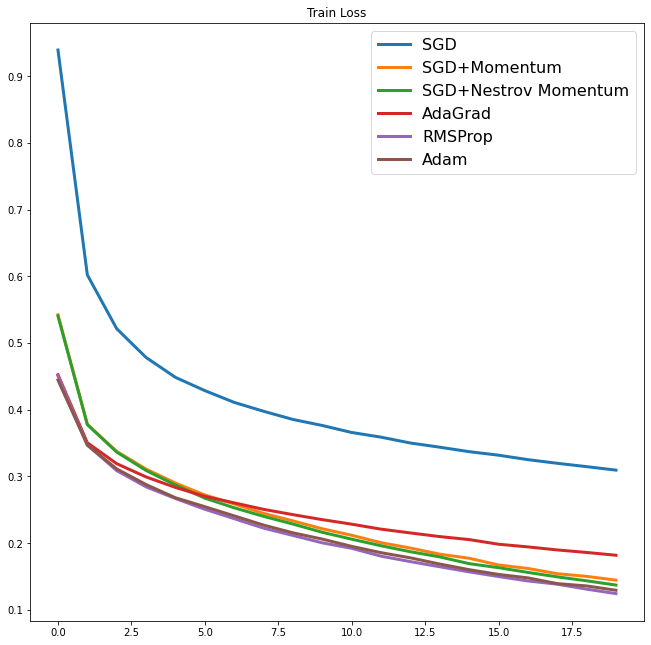

In [57]:
import numpy as np
idx_to_optimizer = {0: "SGD", 1: "SGD+Momentum", 2: "SGD+Nestrov Momentum", 3: "AdaGrad", 4: "RMSProp", 5: "Adam"}

plt.figure(figsize=(11, 11))

x = np.arange(epochs)
for idx, loss_arr in enumerate(train_loss_arr_list):
    plt.plot(x, [l.to("cpu").detach().item() for l in loss_arr], label = idx_to_optimizer[idx], linewidth = 3.0)

plt.title("Train Loss")
plt.legend(fontsize = 16)
plt.show()

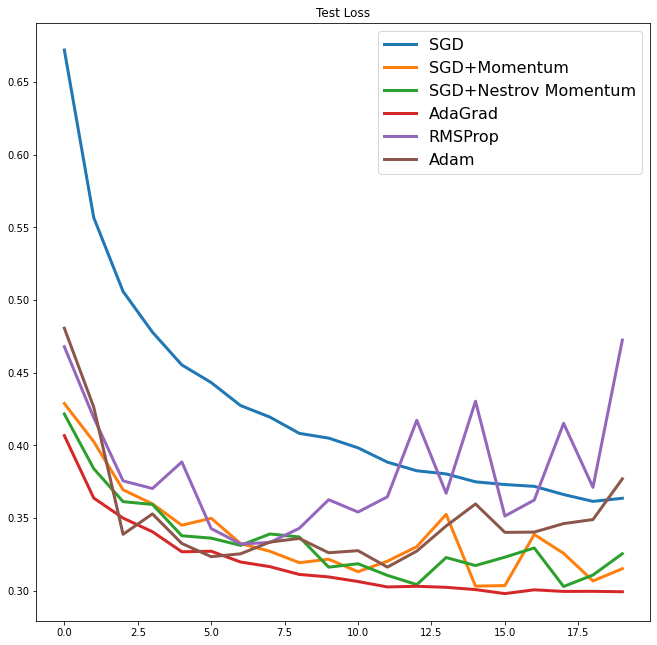

In [58]:
import numpy as np

idx_to_optimizer = {0: "SGD", 1: "SGD+Momentum", 2: "SGD+Nestrov Momentum", 3: "AdaGrad", 4: "RMSProp", 5: "Adam"}

plt.figure(figsize=(11, 11))

x = np.arange(epochs)
for idx, loss_arr in enumerate(test_loss_arr_list):
    plt.plot(x, [l for l in loss_arr], label = idx_to_optimizer[idx], linewidth = 3.0)

plt.title("Test Loss")
plt.legend(fontsize = 16)
plt.show()